
Cluster summaries (mean/std):
               age                        bmi                 risk_score  \
              mean       std count       mean       std count       mean   
cluster                                                                    
0        76.264362  3.734901    35  26.872772  5.116929    35   0.459624   
1        50.406748  4.649742    78  25.839238  4.737406    78   0.528723   
2        63.687839  3.747096    87  26.620436  4.567441    87   0.442006   

                         diabetes                 hypertension            \
              std count      mean       std count         mean       std   
cluster                                                                    
0        0.302000    35  0.371429  0.490241    35     0.342857  0.481594   
1        0.278704    78  0.346154  0.478822    78     0.371795  0.486412   
2        0.304544    87  0.310345  0.465317    87     0.390805  0.490759   

                 statin                  
        count

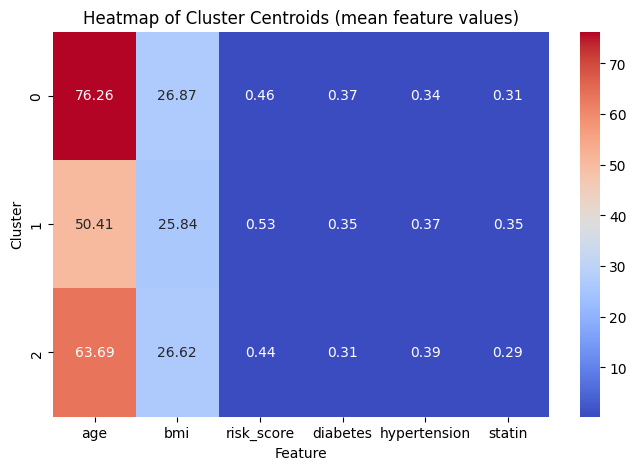

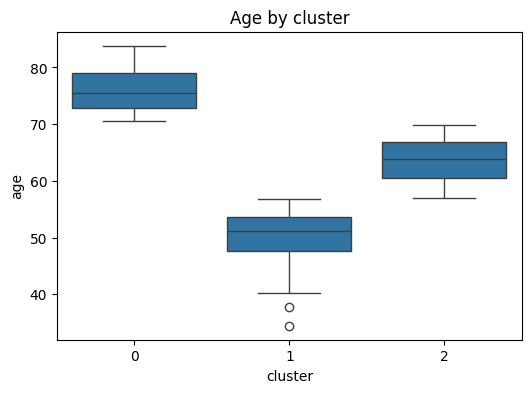

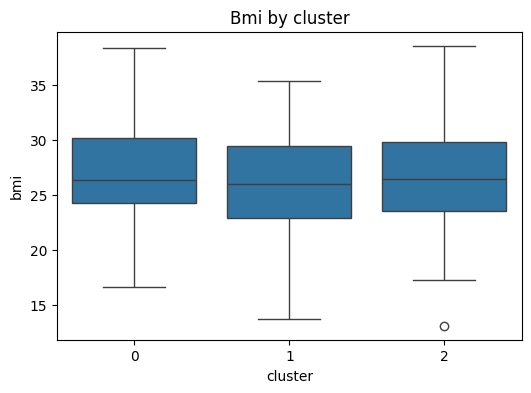

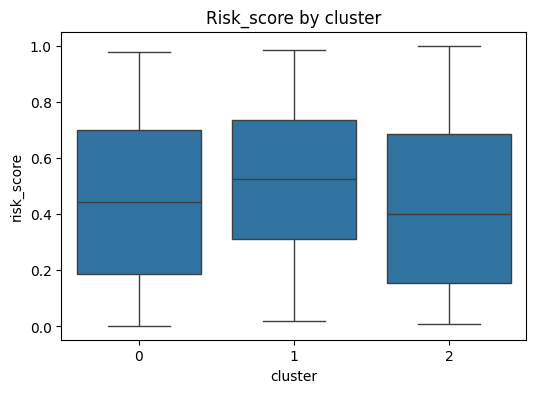

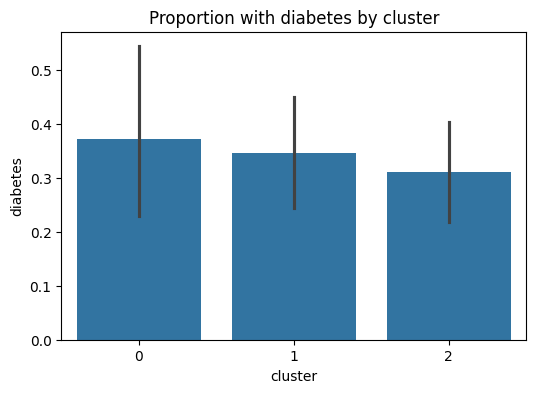

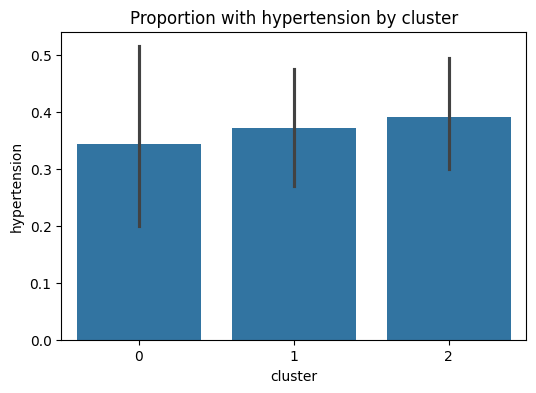

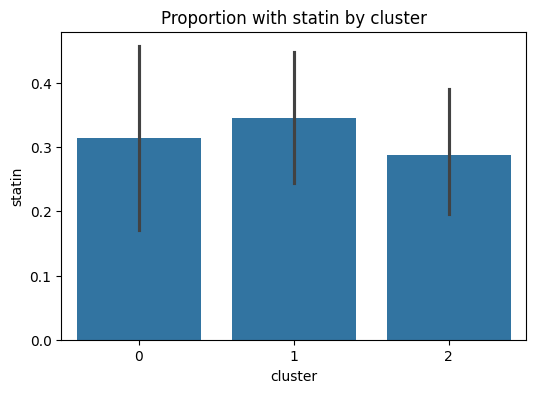

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from scipy import stats
import statsmodels.stats.multitest as smm
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# 1. Generate toy dataset (patients)
# ---------------------------
np.random.seed(0)

# continuous variables
age = np.random.normal(60, 10, 200)
bmi = np.random.normal(27, 5, 200)
risk_score = np.random.uniform(0, 1, 200)

# binary variables (drugs/diseases)
diabetes = np.random.binomial(1, 0.3, 200)
hypertension = np.random.binomial(1, 0.4, 200)
statin = np.random.binomial(1, 0.25, 200)

X = pd.DataFrame({
    'age': age,
    'bmi': bmi,
    'risk_score': risk_score,
    'diabetes': diabetes,
    'hypertension': hypertension,
    'statin': statin
})

# ---------------------------
# 2. Clustering (k-means)
# ---------------------------
km = KMeans(n_clusters=3, random_state=0)
X['cluster'] = km.fit_predict(X)

# ---------------------------
# 3. Summaries
# ---------------------------
summary = X.groupby('cluster').agg(['mean','std','count'])
print("\nCluster summaries (mean/std):")
print(summary)

# ---------------------------
# 4. Statistical tests
# ---------------------------
pvals = {}
for col in ['age','bmi','risk_score']:
    groups = [X.loc[X.cluster==k, col] for k in X.cluster.unique()]
    pvals[col] = stats.kruskal(*groups).pvalue

for col in ['diabetes','hypertension','statin']:
    contingency = pd.crosstab(X[col], X['cluster'])
    chi2, p, dof, ex = stats.chi2_contingency(contingency, correction=False)
    pvals[col] = p

# Multiple testing correction
_, pvals_fdr, _, _ = smm.multipletests(list(pvals.values()), method='fdr_bh')
pvals_corr = dict(zip(pvals.keys(), pvals_fdr))

print("\nCorrected p-values (FDR):")
print(pvals_corr)

# ---------------------------
# 5. Random Forest importance
# ---------------------------
X_feats = X.drop(columns='cluster')
y = X['cluster']
rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(X_feats, y)

perm = permutation_importance(rf, X_feats, y, n_repeats=10, random_state=0)
importances = pd.Series(perm.importances_mean, index=X_feats.columns).sort_values(ascending=False)

print("\nPermutation Importances:")
print(importances)

# ---------------------------
# 6. Visualization
# ---------------------------
# Heatmap of cluster means (continuous and binary features)
plt.figure(figsize=(8,5))
cluster_means = X.groupby('cluster').mean()
sns.heatmap(cluster_means, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title("Heatmap of Cluster Centroids (mean feature values)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.show()

# Boxplots for continuous variables
for col in ['age', 'bmi', 'risk_score']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='cluster', y=col, data=X)
    plt.title(f"{col.capitalize()} by cluster")
    plt.show()

# Barplots for binary features
for col in ['diabetes', 'hypertension', 'statin']:
    plt.figure(figsize=(6,4))
    sns.barplot(x='cluster', y=col, data=X, estimator=np.mean)
    plt.title(f"Proportion with {col} by cluster")
    plt.show()


In [2]:
X

,age,bmi,risk_score,diabetes,hypertension,statin,cluster
0,77.640523,25.154091,0.204924,0,0,0,0
1,64.001572,25.803104,0.341698,0,0,0,2
2,69.787380,32.498298,0.676242,0,1,1,2
3,82.408932,30.276319,0.879235,1,0,1,0
4,78.675580,30.200658,0.543678,1,1,0,0
...,...,...,...,...,...,...,...
195,58.284537,23.192539,0.559682,0,0,0,2
196,67.717906,31.289620,0.773456,1,0,0,2
197,68.235042,32.705509,0.456410,0,0,0,2
198,81.632359,34.332894,0.153369,1,0,1,0
